# Data Exploration

## TODO

- Make visualizations using `train_tweets` data frame

In [1]:
# global imports
import pyspark
from pyspark.sql.session import SparkSession
import pyspark.sql.functions as W
from pyspark.sql.types import StringType, IntegerType, ArrayType
# vectors
from pyspark.ml.linalg import Vectors
# visualization
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
# clustering algorithm
from pyspark.ml.clustering import LDA

spark = SparkSession.builder.getOrCreate()

# Import Data

In [2]:
# import data
%store -r dfs

In [3]:
# import train_tweets data
train_tweets = spark.createDataFrame(dfs[2])
# output dataframe
train_tweets.toPandas().head()

,id,label,negativereason,airline,retweet_count,text,tweet_created
0,1,negative,Bad Flight,US Airways,0,@USAirways yes. Every one of these on every f...,2015-02-19 13:03:35 -0800
1,3,positive,Can't Tell,Delta,0,Sigh... “@JetBlue: Our fleet's on fleek. http:...,2015-02-24 07:13:17 -0800
2,4,negative,Late Flight,Delta,0,@JetBlue Whoa! No tag and you still saw my twe...,2015-02-18 15:37:41 -0800
3,5,positive,Can't Tell,Delta,0,@JetBlue true. Maybe. Wish I had expedited sec...,2015-02-23 11:55:30 -0800
4,6,positive,Can't Tell,US Airways,0,@USAirways will you please start offering more...,2015-02-20 10:09:39 -0800


In [4]:
# import train data
train = spark.createDataFrame(dfs[0])
# output dataframe
train.toPandas().head()

,count_vec,label_idx
0,"(1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, ...",1.0
2,"(1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ...",0.0
3,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
4,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0


In [5]:
# import test data
test = spark.createDataFrame(dfs[1])
# output data frame
test.toPandas().head()

,count_vec,label_idx
0,"(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,"(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
3,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",0.0
4,"(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0


In [6]:
# import vocabulary
vocab = dfs[3]

# Data Visualization

## Word Counts

In [8]:
# function for creating key and value pair of a row
def key_val(row):
    new_row = [(i,row[i]) for i in range(len(row))]
    return new_row

In [9]:
# create dictionary of indices and word counts
word_counts_dict = train.select('count_vec').rdd\
                   .map(lambda row: row.count_vec.toArray())\
                   .map(lambda row: key_val(row))\
                   .flatMap(lambda row: row)\
                   .reduceByKey(lambda x,y: x+y)\
                   .mapValues(lambda x: int(x))\
                   .collectAsMap()

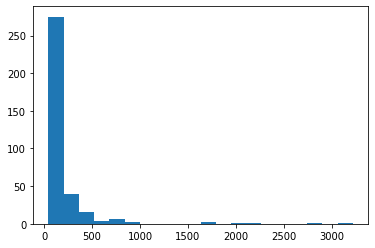

In [30]:
# obtain word counts
word_counts = list(word_counts_dict.values())
# create a histogram of word counts
plt.hist(word_counts,bins=20)
plt.xlabel('Word Counts')
plt.ylabel('Frequency')
plt.title('Histogram of Word Counts')
plt.show()

## `text` Variable

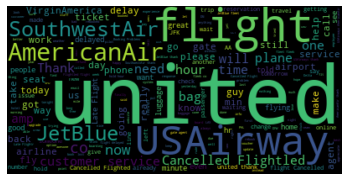

In [7]:
# create an RDD of the tweets
tweets_lst = train_tweets.select('text').rdd.flatMap(lambda row:row).collect()
# create a string of all of the tweets
tweets = ''
for tweet in tweets_lst:
    tweets += tweet
# create a word cloud
wordcloud = WordCloud().generate(tweets)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

# Latent Dirichlet Allocation

## Tune Number of Topics

In [10]:
# FIRST ITERATION
# number of topics to try
ks1 = [5,10,15,20]
log_likelihoods1 = []
# obtain log likelihoods of the LDA for each number of topics
for k in ks1:
    lda_k1 = LDA(featuresCol='count_vec').setK(k).setSeed(414)
    lda_model_k1 = lda_k1.fit(train)
    log_likelihoods1.append(lda_model_k1.logLikelihood(test))

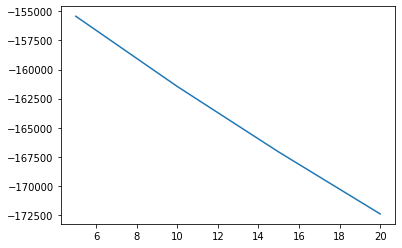

In [11]:
# plot the log likelihood for each number of topics
plt.plot(ks1,log_likelihoods1)
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood of LDA for Various Numbers of Topics')
plt.show()

In [12]:
# SECOND ITERATION
# number of topics to try
ks2 = [2,3,4,5,6,7,8,9]
log_likelihoods2 = []
# obtain log likelihoods of the LDA for teach number of topics
for k in ks2:
    lda_k2 = LDA(featuresCol='count_vec').setK(k).setSeed(414)
    lda_model_k2 = lda_k2.fit(train)
    log_likelihoods2.append(lda_model_k2.logLikelihood(test))

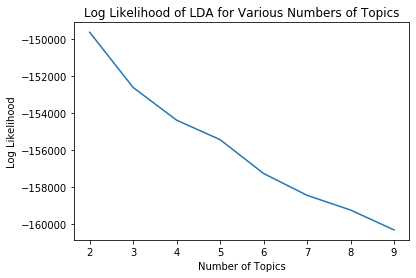

In [32]:
# plot the log likelihood for each number of topics
plt.plot(ks2,log_likelihoods2)
plt.xlabel('Number of Topics')
plt.ylabel('Log Likelihood')
plt.title('Log Likelihood of LDA for Various Numbers of Topics')
plt.show()

## Final Clustering Model

In [14]:
# create final LDA model
lda2 = LDA(featuresCol='count_vec',k=2).setSeed(968)
lda_model2 = lda2.fit(train)
lda_model2.logLikelihood(train)

-348645.8898491999

In [15]:
# obtain topic distribition for each row of the train dataframe
train_topics2 = lda_model2.transform(train)
train_topics2.select('topicDistribution').show(5,truncate=False)

+----------------------------------------+
|topicDistribution                       |
+----------------------------------------+
|[0.4086652535458109,0.5913347464541892] |
|[0.11281045121863284,0.8871895487813671]|
|[0.8810174643905945,0.11898253560940548]|
|[0.798881093930813,0.20111890606918714] |
|[0.44156887524581684,0.5584311247541832]|
+----------------------------------------+
only showing top 5 rows



In [16]:
# obtain term indices for each topic
topics2 = lda_model2.describeTopics(300)
topics2.toPandas().head()

,topic,termIndices,termWeights
0,0,"[1, 4, 0, 5, 6, 10, 3, 11, 9, 15, 13, 2, 14, 1...","[0.061713352936830446, 0.04280486503688341, 0...."
1,1,"[0, 2, 3, 7, 8, 1, 5, 12, 22, 17, 18, 32, 26, ...","[0.06372590380138214, 0.05635446488323972, 0.0..."


In [17]:
# function for converting index to word
def index_to_word(row):
    new_row = []
    for item in row:
        new_row.append(vocab[item])
    return new_row
# udf for converting index to word
index_to_word_udf = W.udf(lambda row: index_to_word(row), ArrayType(StringType()))
# add column of words corresponding to each index
topics2 = topics2.withColumn('topic_words', index_to_word_udf('termIndices'))
# output dataframe
topics2.toPandas().head()

,topic,termIndices,termWeights,topic_words
0,0,"[1, 4, 0, 5, 6, 10, 3, 11, 9, 15, 13, 2, 14, 1...","[0.061713352936830446, 0.04280486503688341, 0....","[united, southwestair, flight, jetblue, get, t..."
1,1,"[0, 2, 3, 7, 8, 1, 5, 12, 22, 17, 18, 32, 26, ...","[0.06372590380138214, 0.05635446488323972, 0.0...","[flight, usairways, americanair, co, http, uni..."


## Word Cloud

In [18]:
# function for whole number of weights (used for word cloud frequencies)
def weights_whole(row):
    weights = []
    for item in row:
        weights.append(int(item*10000))
    return weights
# udf for whole number of weights
weights_whole_udf = W.udf(lambda row: weights_whole(row), ArrayType(IntegerType()))
# add column with whole number of weights
topics2 = topics2.withColumn('weights_whole', weights_whole_udf('termWeights'))
# output dataframe
topics2.toPandas().head()

,topic,termIndices,termWeights,topic_words,weights_whole
0,0,"[1, 4, 0, 5, 6, 10, 3, 11, 9, 15, 13, 2, 14, 1...","[0.061713352936830446, 0.04280486503688341, 0....","[united, southwestair, flight, jetblue, get, t...","[617, 428, 358, 309, 209, 183, 179, 166, 159, ..."
1,1,"[0, 2, 3, 7, 8, 1, 5, 12, 22, 17, 18, 32, 26, ...","[0.06372590380138214, 0.05635446488323972, 0.0...","[flight, usairways, americanair, co, http, uni...","[637, 563, 463, 293, 291, 199, 193, 181, 136, ..."


In [19]:
# function for creating word cloud
def wordcloudplot(lda,topics):
    for k in range(lda.getK()):
        topick = topics.where(W.col('topic') == k)
        topick_dict = {}
        for i,v in zip(topick.select('topic_words').rdd.map(lambda x:x[0]).collect()[0],topick.select('weights_whole').rdd.map(lambda x:x[0]).collect()[0]):
            topick_dict[i] = v
        cloud = WordCloud()
        plt.figure()
        cloud.generate_from_frequencies(topick_dict)
        plt.imshow(cloud)
        plt.axis("off")
        plt.margins(x=0, y=0)
        plt.show()

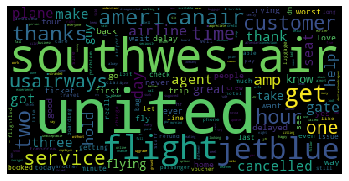

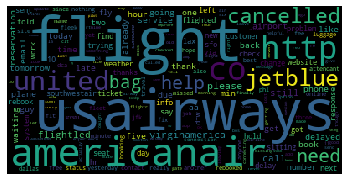

In [20]:
# create word cloud for each topic
wordcloudplot(lda2,topics2)